## Name: Joaquin Quintana

# Setup: OpenCV

For this assignment you will need to use a popular and powerful library known as [OpenCV](https://opencv.org/). To do this on hub, you will need to open a terminal (File->New Launcher->Terminal) and enter `pip install opencv-python`. If you are trying to run the notebook somewhere else and can't figure out how to install the library, ask on piazza and provide details.

# Assignment: Solving Image Maze 

Given a maze as an image with a start and end point, we would like to write code to solve the maze. 

An image is a 2D matrix of pixels of a particular size that depends on its resolution. Each 
pixel has a color which is given by its Red, Green and Blue (RGB) values.
 
Given an image, we will view it as a graph where each pixel of the image is a vertex 
and edges connect a pixel to its neighbor. The weight of an edge should be very small if
the pixel colors are similar (i.e, the differences between r, g and b values are close to zero)
and correspondingly large as the pixel colors diverge.
  
Next, given a source pixel $(i_0, j_0)$ and destination pixel, 
$(i_1, j_1)$, we wish find the shortest weight path from source to destination.

You should use the Dijkstra's algorithm modified in two ways:
   - It can exit as soon as the destination is reached.
   - A 1000 x 1000 pixel image gives rise to a graph with million vertices. Storing such a graph as an adjacency list is going to be very memory intensive. Instead, your goal will be to generate the vertices and edges *on-the-fly*.
   
We will use opencv library, a popular computer vision library to load, and manipulate images of mazes.



## Manipulating Images

You can directly manipulate images in python in many ways. The `opencv` library is considered a standard for numerous
image manipulation tasks.

Here we load an image `maze.png` and you can see it nicely plotted with coordinates. We then show you two pixels
shown in red and blue. The goal here is to detect a path from one of the colored circle to the other, in the maze without crossing
the black pixels.

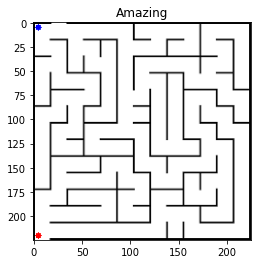

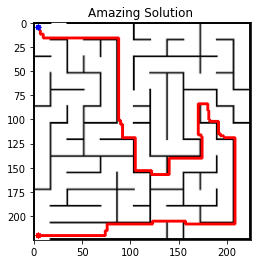

In [1]:
from matplotlib import pyplot as plt
import numpy as np
import cv2
# You can read png, jpg and other file types 
img = cv2.imread('maze.png') # read an image from a file using opencv (cv2) library
# you can annotate images 
cv2.circle(img,(5,220), 3, (255,0,0), -1) # add a circle centered at (5, 220) radius 3, color red (RGB: 255,0,0)
cv2.circle(img, (5,5), 3, (0,0,255), -1) # add a circle centered at (5,5) radius 3, color red (RGB: 0,0,255)
plt.imshow(img) # show the image on the screen 
plt.title('Amazing')
plt.show()

img = cv2.imread('maze-solution.png') # read an image from a file using opencv (cv2) library
# you can annotate images 
cv2.circle(img,(5,220), 3, (255,0,0), -1) # add a circle centered at (5, 220) radius 3, color red (RGB: 255,0,0)
cv2.circle(img, (5,5), 3, (0,0,255), -1) # add a circle centered at (5,5) radius 3, color red (RGB: 0,0,255)
plt.imshow(img) # show the image on the screen 
plt.title('Amazing Solution ')
plt.show()


Given an image it is simple to read the color at a pixel. Let us read the color at pixel (645, 67)

In [2]:
print('Image size (height, width, num layers) is', img.shape)
px = img[145, 67] # img[y,x] is the color of the pixel of x,y
print(px)

cv2.circle(img, (80, 18), 3, (198,31,4),-1) # Draw a colored circle centered at (80, 18)
px1 = img[18, 80] # It is important to note that rows of the image are y values and columns are x values.
print(px1)

px2 = img[80, 18] # This is important to note that indexing the img data structure takes y, x values.
# Most opencv functions will require (x,y) coordinates for pixel as is natural.
print(px2)

Image size (height, width, num layers) is (225, 225, 3)
[255 255 255]
[198  31   4]
[0 0 0]


The pixel color is expressed in RGB format. R is the red value from 0 -> 255, G is the green value 0 -> 255 and B is the blue value from 0 -> 255 

We will now define a edge weight function for an edge in the image



In [3]:
import math 
def fixPixelValues(px):
    # convert the RGB values into floating point to avoid an overflow that will give me wrong answers
    return [ float(px[0]), float(px[1]), float(px[2]) ]

## Given (x,y) coordinates of two neighboring pixels, calculate the edge weight.
# We take the squared euclidean distance between the pixel values and add 0.1
def getEdgeWeight(img, u, v):
    # get edge weight for edge between u, v
    # First make sure that the edge is legit
    i0,j0 = u[0], u[1]
    i1,j1 = v[0], v[1]
    height, width, _ = img.shape
    assert i0 >= 0 and j0 >= 0 and i0 < width and j0 < height # pixel position valid?
    assert i1 >= 0 and j1 >= 0 and i1 < width and j1 < height # pixel position valid?
    assert -1 <= i0 - i1 <= 1 # edge between node and neighbor?
    assert -1 <= j0 - j1 <= 1
    px1 = fixPixelValues(img[j0,i0])
    px2 = fixPixelValues(img[j1,i1])
    return 0.1 + (px1[0] - px2[0])**2 + (px1[1] - px2[1])**2 + (px1[2]- px2[2])**2
    
# This is a useful function that given a list of (x,y) values, 
# draw a series of red lines between each coordinate and next to 
# show the path in the image
def drawPath(img, path, pThick=2):
    v = path[0]
    x0, y0 = v[0], v[1]
    for v in path:
        x, y = v[0], v[1]
        cv2.line(img,(x,y), (x0,y0), (255,0,0),pThick)
        x0, y0 = x,y
        

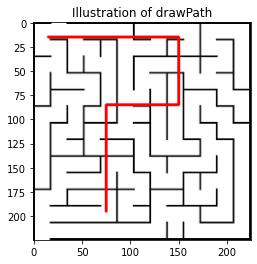

In [4]:
# Example
img = cv2.imread('maze.png') # read an image from a file using opencv (cv2) library
drawPath(img, [ (15, 15), (150, 15), (150, 85), (75, 85), (75, 195)])
plt.imshow(img) # show the image on the screen 
plt.title('Illustration of drawPath')
plt.show()

## Step 1: Compute Single Source Shortest Path For an Image

Given an image, compute the  shortest path between source and destination pixels by modifying Dijkstra's algorithm. __Your challenge  is to implement it without needing to create the entire the adjacency list for the graph
in the first place. However, for simplicity you can try a first cut implementation of a generic Dijkstra algorithm over
graphs represented as adjacency matrix or list.__ 

In [5]:
class Vertex: # This is the outline for a vertex data structure
    def __init__ (self,  i, j):
        self.x = i # The x coordinate
        self.y = j  # The y coordinate
        self.d = float('inf') # the shortest path estimate
        self.processed = False # Has this vertex's final shortest path distance been computed
        self.idx_in_priority_queue = -1 # The index of this vertex in the queue
        self.pi = None # the parent vertex.
        #create pointer to the vertex's neightbors
        self.n = None
        self.s = None
        self.e = None
        self.w = None
    
        
# Dijkstra's algorithm requires a priority queue so that the 
# minimum weight vertex can be found efficiently.
# However, we provide you with a list data structure as a stand in for priority queue

class SimpleQueue: 
    # CONSTRUCTOR
    def __init__(self): 
        self.q = []
        
    # Insert a vertex into the queue
    def insert(self, v):
        v.idx_in_priority_queue = len(self.q)
        self.q.append(v)
        
    # Find the vertex with the smallest distance estimate, and 
    # delete it from the queue
    # return the vertex
    def get_and_delete_min(self):
        n = len(self.q)
        assert n > 0
        min_pos = 0
        for i in range(n):
            if self.q[i].d < self.q[min_pos].d:
                min_pos = i
        v = self.q[min_pos]
        del self.q[min_pos]
        return v
    
    # Is the queue empty?
    def is_empty(self):
        return len(self.q) == 0
    
    # Notify the queue that the weight of vertex v has been updated.
    def update_vertex_weight(self, v):
        pass # Nothing to do, for a simple list, we ignore this notification.
    


In [6]:
class Vertex: # This is the outline for a vertex data structure
    def __init__ (self,  i, j):
        self.x = i # The x coordinate
        self.y = j  # The y coordinate
        self.d = float('inf') # the shortest path estimate
        self.processed = False # Has this vertex's final shortest path distance been computed
        self.idx_in_priority_queue = -1 # The index of this vertex in the queue
        self.pi = None # the parent vertex.
        #create pointer to the vertex's neightbors
        self.n = None
        self.s = None
        self.e = None
        self.w = None

# However, if you want Dijkstra efficiently, 
# you may want to implement a priority queue.
# We provide you the signature for a priority queue.
# Feel free to implement extra functions if you wish
class PriorityQueue:
    # Constructor: 
    def __init__(self):
        self.q = [] #for vertexes to heap
        pass # YOUR CODE HERE
    
    def insert(self, v):
        v.idx_in_priority_queue = len(self.q)
        self.q.append(v)

    def build_min_heap(self):
            #takes and array and builds a min heap
        nhalf = (len(self.q)-1)//2

        for i in range(nhalf,-1,-1):
            self.min_heapify(i)
        #return self.q
    
    def min_heapify(self,i):
    #given a node the function min heapifies the parent and childeren if out of order.
        l = 2*i + 1
        r = 2*i + 2

        #print(self.q[l].d < self.q[i].d)

        if l <= len(self.q)- 1 and self.q[l].d < self.q[i].d:
            minfound = l
        else:
            minfound = i
        
        if r <= len(self.q) - 1 and self.q[r].d < self.q[minfound].d:
            minfound = r
        
        if minfound != i:
            #swap
            temp = self.q[i]
            self.q[i] = self.q[minfound]
            self.q[minfound] = temp
#update index information in Q
            #self.q[i].idx_in_priority_queue = i
            #self.q[minfound].idx_in_priority_queue = minfound

            self.min_heapify(minfound) 
        
        return self.q
    
    def bubbleUp(self,v):

        # i need a  way of tracking the index of the nodes in the Q
        # This is, as I remove an item the node index does not 
        # get the index for its current position         
        keyId = self.q.index(v)

        if keyId%2 == 0:#even and right chiled
            parentid = keyId//2 -1
        else:#odd and left chiled
            parentid = keyId//2

        while keyId > 0 and self.q[keyId].d < self.q[parentid].d:            
            temp = self.q[keyId]
            self.q[keyId] = self.q[parentid]
            self.q[parentid] = temp
            keyId = parentid

            if keyId%2 == 0:#even and right chiled
                parentid = keyId//2 -1
            else:#odd and left chiled
                parentid = keyId//2

    def get_and_delete_min(self):
        #takes min heap and gets min in minheap 
        #this removes first object in the array and the heap needs to be heapified
        temp = self.q[0]
        self.q[0] = self.q[-1]
        self.q[-1] = temp 

        v = self.q.pop(-1)
        v.processed = True
        
        #runs if minheap is not being updated correctly
        if v.d == float('Inf'):
            Q.build_min_heap()
            print('v.d = Inf')

        self.min_heapify(0)
        #self.build_min_heap()
        
        return v # YOUR CODE HERE: must return a vertex
    
    def is_empty(self):
        return len(self.q) == 0 # YOUR CODE HERE: must return true/false
        
    def update_vertex_weight(self, u):
        y,x = u.y,u.x  # The x,y coordinate

        #relax adjacent edges if the vertex being reached from u 
        #has not already been vistied
        for i in [u.n,u.e,u.s,u.w]:
            if i and i not in S: 
                v = i
                #print('points north')
                weight = getEdgeWeight(img,(x,y),(v.x,v.y))

                #check if we should relax edge
                if  (u.d + weight) < v.d:
                    v.d = u.d + weight
                    v.pi = u
                    #update postion in heap after updating v
                    Q.bubbleUp(v)
        

In [21]:
def computeShortestPath(img, source, dest): 
    global Q, S
    
    source = (source[1],source[0])
    dest = (dest[1],dest[0])
    
    Q = PriorityQueue()

    print(Q.is_empty())

    ysize,xsize,_ = img.shape

    #create a matrix to work with Vertex or object data type
    maze = np.empty((ysize,xsize) ,dtype=object) 

    #Use class vertex to set this problem up or intiate each node. 
    for row in range(xsize):
        for column in range(ysize):
            maze[column][row] = Vertex(row,column)        
            Q.insert(maze[column][row])

    for row in range(xsize):
        for column in range(ysize):
            if column+1 >= 0 and column+1 < ysize:
                maze[column][row].n = maze[column+1][row] 
            if row-1 >= 0:
                maze[column][row].w = maze[column][row-1] 
            if row+1 >= 0 and row +1 < xsize:
                maze[column][row].e = maze[column][row+1] 
            if column-1 >= 0:
                maze[column][row].s = maze[column-1][row] 

    #set source node to have distance = 0
    maze[source[0]][source[1]].d = 0
    #set parent node to itself for source
    maze[source[0]][source[1]].pi = maze[source[0]][source[1]]

    #print(np.unravel_index(0, (ysize, xsize)))
    #build min heap from intialized vertexes
    Q.build_min_heap()

    S = []

    while (Q.is_empty() == False):
            #get vertex with min distance which has not been visited yet
        u = Q.get_and_delete_min()
                                            
        S.append(u)
        #update all adjacet edge weight from u to v. Retrun the min of the
        #edges
        Q.update_vertex_weight(u)
        #seach until we reach our destination 
        if u == maze[dest[0]][dest[1]]:
            path = []
            #This will stop at the node right before the source. Unsure if path is real.......
            u = maze[dest[0]][dest[1]]
            while u.pi != u:
                path.append((u.x,u.y))

                #update parent to be u 
                u = u.pi
            return path

In [8]:
def resize(img,percent):

    #convert image to gray scale and binarize so we only have black and white pixels 
    #gray =  cv2.imread(fileName,cv2.IMREAD_GRAYSCALE)
    #resize image
    
    resized= cv2.resize(img, (0,0), fx=percent, fy=percent,interpolation = cv2.INTER_AREA) 

    #convert to binary usings Otsu's method
    #thresh, bw =  cv2.threshold(resized,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

    #convert image now it is cleaned up back to color and find path
    #img  =  cv2.cvtColor(bw,cv2.COLOR_GRAY2RGB) 

    return resized

In [9]:
img = cv2.imread('maze.png') # read an image from a file using opencv (cv2) library
p = computeShortestPath(img, (5,220), (5,5))

True
220 5


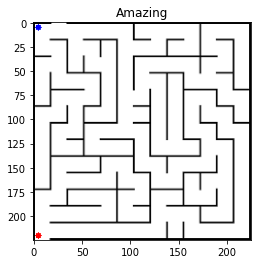

In [10]:
img = cv2.imread('maze.png') # read an image from a file using opencv (cv2) library
# you can annotate images 
cv2.circle(img,(5,220), 3, (255,0,0), -1) # add a circle centered at (5, 220) radius 3, color red (RGB: 255,0,0)
cv2.circle(img, (5,5), 3, (0,0,255), -1) # add a circle centered at (5,5) radius 3, color red (RGB: 0,0,255)
plt.imshow(img) # show the image on the screen 
plt.title('Amazing')
plt.show()

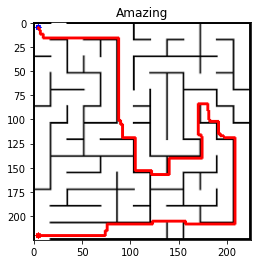

True

In [11]:
drawPath(img, p, 2)
plt.imshow(img) # show the image on the screen 
plt.title('Amazing')
plt.show()
cv2.imwrite('maze-solution.png', img)

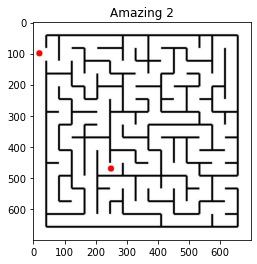

In [12]:
img = cv2.imread('maze2.JPG') # read an image from a file using opencv (cv2) library
cv2.circle(img,(250,470), 10, (255,0,0), -1) # add a circle centered at (600, 70) radius 10, color red (RGB: 255,0,0)
cv2.circle(img, (20,100), 10, (255,0,0), -1) # add a circle centered at (790,200) radius 10, color red (RGB: 255,0,0)
plt.imshow(img) # show the image on the screen 
plt.title('Amazing 2')
plt.show()

In [13]:
percent = 0.2
x,y = 250,470
dx,dy = 20,100
x = percent*x
y = percent *y
dx = percent*dx
dy = percent*dy
source  = (int(x),int(y))
dest = (int(dx),int(dy))

In [14]:
imgOG = cv2.imread('maze2.JPG') # read an image from a file using opencv (cv2) library
img  = resize(imgOG, percent)
p = computeShortestPath(img, source, dest)
#p = computeShortestPath(img, (250,470), (20,100))

True
94 50


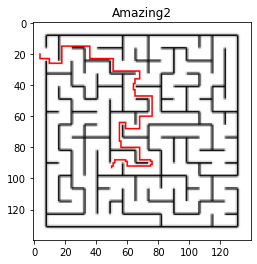

In [15]:
drawPath(img,p,1)
plt.imshow(img) # show the image on the screen 
plt.title('Amazing2')
plt.show()

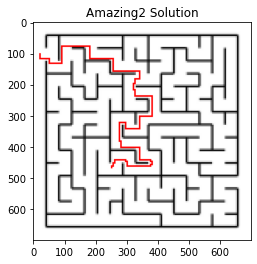

True

In [16]:
#show the solved image as its orginal size
#This image will be at a lower resolution than the orginal.
lowerres = cv2.resize(img, (0,0), fx=5.0, fy=5.0,interpolation = cv2.INTER_AREA)

plt.imshow(lowerres) # show the image on the screen 
plt.title('Amazing2 Solution')
plt.show()
cv2.imwrite('maze2-solution.png', lowerres)

## Processing Maze3

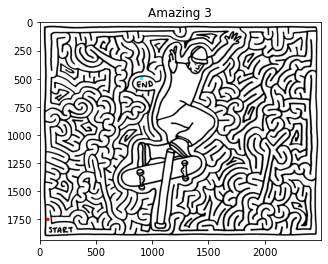

In [17]:
img = cv2.imread('maze3.JPG')
cv2.circle(img,(70,1750), 15, (255,0,0), -1) # add a circle centered at (600, 70) radius 10, color red (RGB: 255,0,0)
cv2.circle(img, (900,500), 15, (0,255,255), -1) # add a circle centered at (790,200) radius 10, color red (RGB: 255,0,0)
plt.imshow(img) # show the image on the screen 
plt.title('Amazing 3')
plt.show()

In [18]:
img = cv2.imread('maze3.JPG')
#shirnk the image as they are to large
img = cv2.resize(img, (0,0), fx=0.2, fy=0.2,interpolation = cv2.INTER_AREA) 
x = 0.2*80
y = 0.2 *1800
dx = 0.2*900
dy = 0.2*500
source  = (int(x),int(y))
dest = (int(dx),int(dy))
p = computeShortestPath(img, source, dest)

True
360 16


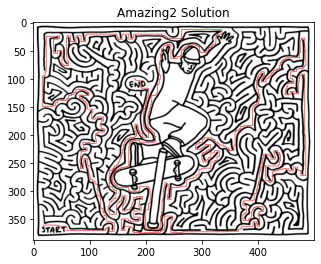

In [19]:
drawPath(img,p,1)
plt.imshow(img) # show the image on the screen 
plt.title('Amazing2 Solution')
plt.show()

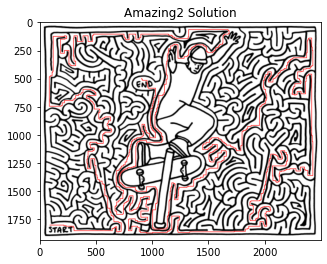

True

In [20]:
lowerres = cv2.resize(img, (0,0), fx=5.0, fy=5.0,interpolation = cv2.INTER_AREA)
plt.imshow(lowerres) # show the image on the screen 
plt.title('Amazing2 Solution')
plt.show()
cv2.imwrite('maze3-solution.png', lowerres)